# 0. Getting started with CapyMOA

This notebook shows some basic usage of CapyMOA for supervised learning (classification and regression)
* There are more detailed notebooks and documentation available, our goal here is just present some high-level functions and demonstrate a subset of CapyMOA's functionalities. 
* For simplicity, we simulate data streams in the following examples using datasets and employing synthetic generators. One could also read data directly from a CSV or ARFF (See [stream_from_file](https://capymoa.org/api/stream.html#capymoa.stream.stream_from_file) function)

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 25/07/2024**

## 1. Classification

* Classification for data streams tradicionally assumes instances are available to the classifier in an incremental fashion and labels become available before a new instance becomes available
* It is common to simulate this behavior using a **while loop**, often referred to as a **test-then-train loop** which contains 4 distinct steps:
    1. Fetches the next instance from the stream
    2. Makes a prediction
    3. Train the model with the instance
    4. Update a mechanism to keep track of metrics

**Some remarks about test-then-train loop**:
* We must not train before testing, meaning that steps 2 and 3 should not be interchanged, as this would invalidate our interpretation concerning how the model performs on unseen data, leading to unreliable evaluations of its efficacy. 
* Steps 3 and 4 can be completed in any order without altering the result. 
* What if labels are not immediately available? Then you might want to read about delayed labeling and partially labeled data, see [A Survey on Semi-supervised Learning for Delayed Partially Labelled Data Streams](https://dl.acm.org/doi/full/10.1145/3523055)
* More information on classification for data streams is available on section **2.2 Classification** from [Machine Learning for Data Streams](https://moa.cms.waikato.ac.nz/book-html/) book


In [1]:
from capymoa.datasets import Electricity
from capymoa.evaluation import ClassificationEvaluator
from capymoa.classifier import OnlineBagging

elec_stream = Electricity()
ob_learner = OnlineBagging(schema=elec_stream.get_schema(), ensemble_size=5)
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = ob_learner.predict(instance)
    ob_learner.train(instance)
    ob_evaluator.update(instance.y_index, prediction)

print(ob_evaluator.accuracy())

82.06656073446328


### 1.1 High-level evaluation functions

* If our goal is just to evaluate learners it would be tedious to keep writing **test-then-train loops**. 
Thus, it makes sense to encapsulate that loop inside **high-level evaluation functions**. 

* Furthermore, sometimes we are interested in **cumulative metrics** and sometimes we care about metrics **windowed metrics**. For example, if we want to know how accurate our model is so far, considering all the instances it has seen, then we would look at its **cumulative metrics**. However, we might also be interested in how well the model is every **n** number of instances, so that we can, for example, identify periods in which our model was really struggling to produce correct predictions. 

* In this example, we use the ```prequential_evaluation``` function, which provides us with both the cumulative and the windowed metrics! 

* Some remarks:
    * If you want to know more about other **high-level evaluation functions**, **evaluators**, or which **metrics** are available, check the **01_evaluation** notebook
    * The **results** from evaluation functions such as **prequential_evaluation** follow a standard, also discussed thoroughly in the **Evaluation documentation** in http://www.capymoa.org
    * Sometimes authors refer to the **cumulative** metrics as **test-then-train** metrics, such as **test-then-train accuracy** (or TTT accuracy for short). They all refer to the same concept.
    * Shouldn't we recreate the stream object ```elec_stream```? No, `prequential_evaluation()`, by default, automatically ```restart()``` streams when they are reused.

In the below example `prequential_evaluation` is used with a `HoeffdingTree` classifier on the `Electricity` data stream.

In [2]:
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import HoeffdingTree

ht = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)

# Obtain the results from the high-level function. 
    # Note that we need to specify a window_size as we obtain both windowed and cumulative results. 
    # The results from a high-level evaluation function are represented as a PrequentialResults object
results_ht = prequential_evaluation(stream=elec_stream, learner=ht, window_size=4500)

print(f"Cumulative accuracy = {results_ht.cumulative.accuracy()}, wall-clock time: {results_ht.wallclock()}")

# The windowed results are conveniently stored in a pandas DataFrame. 
display(results_ht.windowed.metrics_per_window())

Cumulative accuracy = 81.6604872881356, wall-clock time: 0.25900697708129883


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,4500.0,87.777778,74.440796,24.242424,68.856172,87.222016,84.550562,89.889706,87.149807,84.078212,90.221402,87.294344,85.028249,89.560440
1,9000.0,83.666667,66.963969,2.649007,64.458414,83.538542,81.657100,85.279391,83.752489,84.373388,83.131589,83.325685,79.110251,87.541118
2,13500.0,85.644444,71.282626,2.269289,70.009285,85.663875,85.304823,85.968723,85.634554,83.780161,87.488948,85.693216,86.886006,84.500427
3,18000.0,81.977778,61.953129,-25.154321,57.021728,81.463331,76.168087,85.510095,82.841248,85.488127,80.194370,80.130502,68.680445,91.580559
4,22500.0,86.177778,70.202882,13.370474,64.719229,85.389296,80.931944,89.159986,86.648480,88.058706,85.238254,84.166185,74.872377,93.459993
5,27000.0,78.088889,53.951820,-72.377622,47.272727,77.186522,71.634062,82.150615,77.962693,77.521793,78.403594,76.425652,66.577540,86.273764
6,31500.0,79.066667,55.619360,-71.897810,46.263548,77.829775,72.504378,83.100108,78.081099,74.237896,81.924301,77.580064,70.849971,84.310157
7,36000.0,74.955556,49.002474,-89.411765,37.354086,74.661963,70.719667,78.120753,74.256346,66.390244,82.122449,75.072035,75.653141,74.490929
8,40500.0,74.555556,50.130218,-71.664168,41.312148,76.116886,74.818562,74.286998,76.196815,65.523883,86.869748,76.037125,87.186058,64.888191
9,45000.0,84.377778,68.535062,-0.428571,68.390288,84.268304,82.949309,85.585401,84.249034,82.648623,85.849445,84.287584,83.252191,85.322976


### 1.2 Comparing results among classifiers

* CapyMOA provides ```plot_windowed_results``` as an easy visualization function for quickly comparing **windowed metrics**
* In the example below, we create three classifiers: HoeffdingAdaptiveTree, HoeffdingTree and AdaptiveRandomForest, and plot the results using ```plot_windowed_results```
* More details about ```plot_windowed_results``` options are described in the documentation: http://www.capymoa.org

HAT accuracy = 84.68617584745762
HT accuracy = 81.6604872881356
ARF accuracy = 81.90766242937853


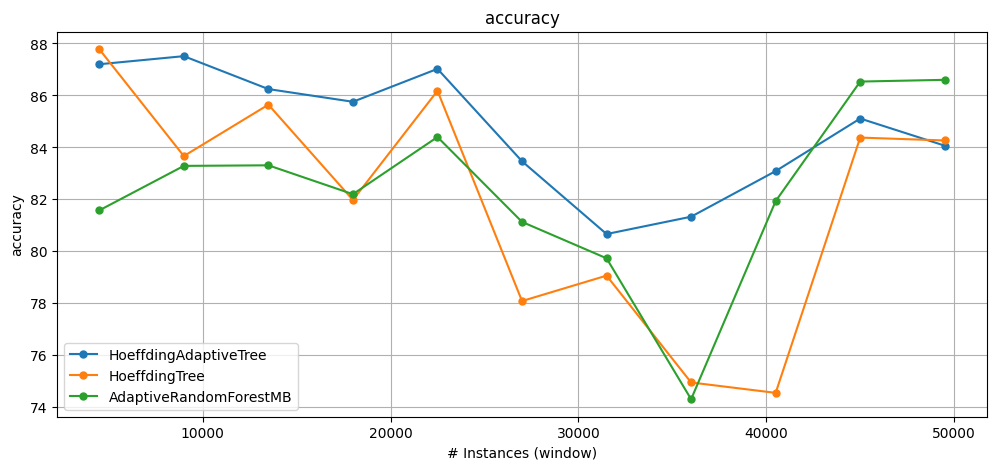

In [3]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.base import MOAClassifier
from moa.classifiers.trees import HoeffdingAdaptiveTree
from capymoa.classifier import HoeffdingTree
from capymoa.classifier import AdaptiveRandomForestClassifier

# Create the wrapper for HoeffdingAdaptiveTree (from MOA)
HAT = MOAClassifier(schema=elec_stream.get_schema(), moa_learner=HoeffdingAdaptiveTree, CLI="-g 50")
HT = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)
ARF = AdaptiveRandomForestClassifier(schema=elec_stream.get_schema(), ensemble_size=10, number_of_jobs=4)

results_HAT = prequential_evaluation(stream=elec_stream, learner=HAT, window_size=4500)
results_HT = prequential_evaluation(stream=elec_stream, learner=HT, window_size=4500)
results_ARF = prequential_evaluation(stream=elec_stream, learner=ARF, window_size=4500)

# Comparing models based on their cumulative accuracy
print(f"HAT accuracy = {results_HAT.cumulative.accuracy()}")
print(f"HT accuracy = {results_HT.cumulative.accuracy()}")
print(f"ARF accuracy = {results_ARF.cumulative.accuracy()}")

# Plotting the results. Note that we ovewrote the ylabel, but that doesn't change the metric. 
plot_windowed_results(results_HAT, results_HT, results_ARF, metric="accuracy", xlabel="# Instances (window)")

## 2. Regression

* Regression algorithms have its API usage very similar to classification algorithms. We can use the same high-level evaluation and visualization functions for regression and classification.
* Similarly to classification, we can also use MOA objects through a generic API. 

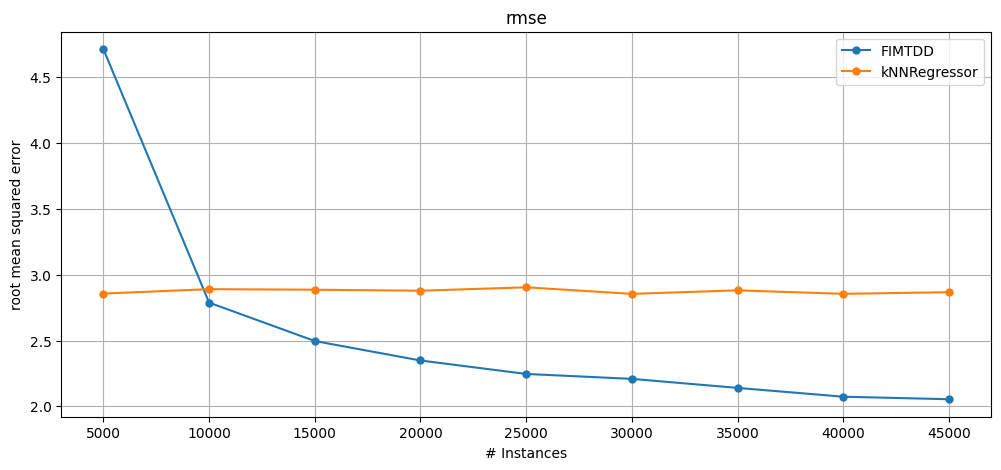

In [4]:
from capymoa.datasets import Fried
from moa.classifiers.trees import FIMTDD
from capymoa.base import MOARegressor
from capymoa.regressor import KNNRegressor

fried_stream = Fried()  # Downloads the Fried dataset into the data dir in case it is not there yet. 
fimtdd = MOARegressor(schema=fried_stream.get_schema(), moa_learner=FIMTDD())
knnreg = KNNRegressor(schema=fried_stream.get_schema(), k=3, window_size=1000)

results_fimtdd = prequential_evaluation(stream=fried_stream, learner=fimtdd, window_size=5000)
results_knnreg = prequential_evaluation(stream=fried_stream, learner=knnreg, window_size=5000)

results_fimtdd.windowed.metrics_per_window()
# Note that the metric is different from the ylabel parameter, which just overrides the y-axis label.
plot_windowed_results(results_fimtdd, results_knnreg, metric="rmse", ylabel="root mean squared error")

## 3. Concept Drift

* One of the most challenging and defining aspects of data streams is the phenomenon known as **concept drifts**.
* In CapyMOA, we designed the simplest and most complete API for simulating, visualizing and assessing concept drifts.
* In the example below we focus on a simple way of simulating and visualizing a drifting stream. There is a tutorial focusing entirely on how Concept Drift can be simulated, detected and assessed in a separate notebook (See **Tutorial 4**: `Simulating Concept Drifts with the DriftStream API`)

### 3.1 Plotting Drift Detection results

* This example uses the DriftStream building API, precisely the **positional version** where drifts are specified according to their exact location on the stream.
* **Integration with the visualization function.** The DriftStream object carries meta-information about the drift which is passed along the stream and thus become available to ```plot_windowed_results```

* The following plot contains two drifts: 1 abrupt and 1 gradual, such that the abrupt drift is located at instance 5000 and the gradual drift starts at instance 9000 and ends at 12000. This information is provided to the stream via ```GradualDrift(start=9000, end=12000)```

* More details concerning Concept Drift in CapyMOA can be found in the documentation: http://www.capymoa.org

None


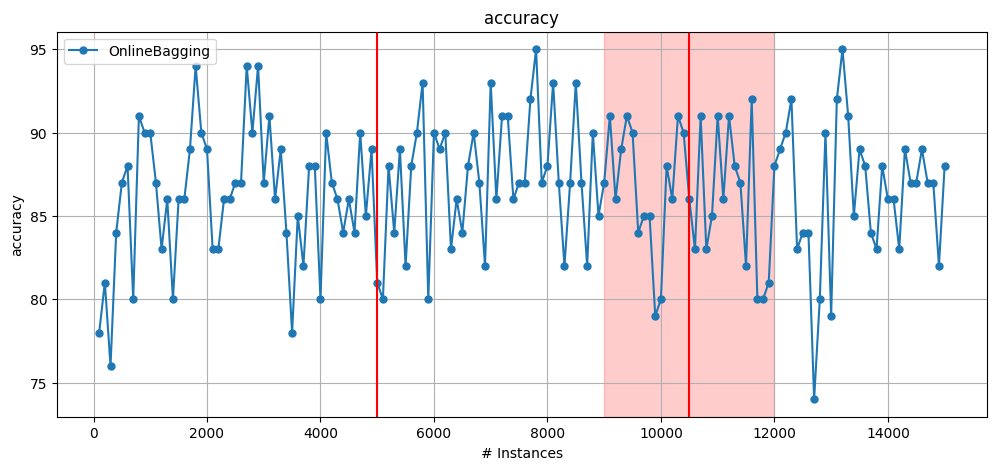

In [5]:
from capymoa.classifier import OnlineBagging
from capymoa.stream.generator import SEA 
from capymoa.stream.drift import Drift, AbruptDrift, GradualDrift, DriftStream

# Generating a synthetic stream with 1 abrupt drift and 1 gradual drift. 
stream_sea2drift = DriftStream(stream=[SEA(function=1), 
                                AbruptDrift(position=5000), 
                                SEA(function=3), 
                                GradualDrift(start=9000, end=12000),
                                SEA(function=1)])

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

# Since this is a synthetic stream, max_instances is needed to determine the amount of instances to be generated. 
results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000)

# print(stream_sea2drift.drifts)
plot_windowed_results(results_sea2drift_OB, metric="accuracy")

# 1. Evaluating supervised learners in CapyMOA

This notebook further explores **high-level evaluation functions**, **Data Abstraction** and **Classifiers**

* **High-level evaluation functions**
    * We demonstrate how to use ```prequential_evaluation()``` and how to further encapsulate prequential evaluation using ```prequential_evaluation_multiple_learners```
    * We also discuss particularities about how these evaluation functions relate to how research has developed in the field, and how evaluation is commonly performed and presented.

* **Supervised Learning**
    * We clarify important information concerning the usage of **Classifiers** and their predictions
    * We added some examples using **Regressors**, which highlight the fact that the evaluation is identical to **Classifiers** (i.e. same high-level evaluation functions)
 
---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 25/07/2024**

## 1. The difference between Evaluators

* The following example implements an **while loop** that updates a ```ClassificationWindowedEvaluator``` and a ```ClassificationEvaluator``` for the same learner. 
* The ```ClassificationWindowedEvaluator``` update the metrics according to tumbling windows which 'forgets' old correct and incorrect predictions. This allows us to observe how well the learner performs on shorter windows. 
* The ```ClassificationEvaluator``` updates the metrics taking into account all the correct and incorrect predictions made. It is useful to observe the overall performance after processing hundreds of thousands of instances.

* **Two important points**:
    1. Regarding **window_size** in ```ClassificationEvaluator```: A ```ClassificationEvaluator``` also allow us to specify a window size, but it only controls the frequency at which cumulative metrics are calculated.
    2. If we access metrics directly (not through ```metrics_per_window()```) in ```ClassificationWindowedEvaluator``` we will be looking at the metrics corresponding to the last window.
 
For further insight into the specifics of the Evaluators, please refer to the documentation: https://www.capymoa.org

In [1]:
from capymoa.datasets import Electricity
from capymoa.evaluation import ClassificationWindowedEvaluator, ClassificationEvaluator
from capymoa.classifier import AdaptiveRandomForestClassifier

stream = Electricity()

ARF = AdaptiveRandomForestClassifier(schema=stream.get_schema(), ensemble_size=10)

# The window_size in ClassificationWindowedEvaluator specifies the amount of instances used per evaluation
windowedEvaluatorARF = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=4500)
# The window_size ClassificationEvaluator just specifies the frequency at which the cumulative metrics are stored
classificationEvaluatorARF = ClassificationEvaluator(schema=stream.get_schema(), window_size=4500)

while stream.has_more_instances():
    instance = stream.next_instance()
    prediction = ARF.predict(instance)
    windowedEvaluatorARF.update(instance.y_index, prediction)
    classificationEvaluatorARF.update(instance.y_index, prediction)
    ARF.train(instance)

# Showing only the 'classifications correct (percent)' (i.e. accuracy)
print(f'[ClassificationWindowedEvaluator] Windowed accuracy reported for every window_size windows')
print(windowedEvaluatorARF.accuracy())

print(f'[ClassificationEvaluator] Cumulative accuracy: {classificationEvaluatorARF.accuracy()}')
# We could report the cumulative accuracy every window_size instances with the following code, but that is normally not very insightful. 
# display(classificationEvaluatorARF.metrics_per_window())

[ClassificationWindowedEvaluator] Windowed accuracy reported for every window_size windows
[89.57777777777778, 89.46666666666667, 90.2, 89.71111111111111, 88.68888888888888, 88.48888888888888, 87.6888888888889, 88.88888888888889, 89.28888888888889, 91.06666666666666]
[ClassificationEvaluator] Cumulative accuracy: 89.32953742937853


## 2. High-level evaluation functions

In CapyMOA, for supervised learning, there is one primary evaluation function designed to handle the manipulation of Evaluators, i.e. the `prequential_evaluation()`. This function streamline the process, ensuring users need not directly update them. Essentially, this function execute the evaluation loop and update the relevant Evaluators:

`prequential_evaluation()` utilises `ClassificationEvaluator` and `ClassificationWindowedEvaluator`

Previously, CapyMOA included two other functions: `cumulative_evaluation()` and `windowed_evaluation()`. However, since `prequential_evaluation()` incorporates the functionality of both we decided to remove those functions and focus on `prequential_evaluation()`.
It's important to note that `prequential_evaluation()` is applicable to both `Regression` and `Prediction Intervals` besides `Classification`. The functionality and interpretation remain the same across these cases, but the metrics differ.

**Result of a high-level function**
* The return from `prequential_evaluation()` is a `PrequentialResults` object which provides access to the `cumulative` and `windowed` metrics as well as some other metrics (like wall-clock and cpu time).

**Common characteristics for all high-level evaluation functions**
* `prequential_evaluation()` specify a `max_instances` parameter, which by default is `None`. Depending on the source of the data (e.g. a real stream or a synthetic stream) the function will never stop! The intuition behind this is that Streams are infinite, we process them as such. Therefore, it is a good idea to specify `max_instances` unless you are using a snapshot of a stream (i.e. a `Dataset` like `Electricity`)

**Evaluation practices in the literature (and practice)**

Interested readers might want to peruse section **6.1.1 Error Estimation** from [Machine Learning for Data Streams](https://moa.cms.waikato.ac.nz/book-html/) book. We further expand the relationships between the literature and our evaluation functions in the documentation: https://www.capymoa.org

### 2.1 prequential_evaluation()

A `prequential_evaluation()` performs a windowed evaluation and a cumulative evaluation at once. Internally, it maintains a `ClassificationWindowedEvaluator` (for the windowed metrics) and ```ClassificationEvaluator``` (for the cumulative metrics). This allows us to have access to the **cumulative** and **windowed** results without running two separate evaluation functions. 

* The results returned from ```prequential_evaluation()``` allows accessing the Evaluator objects ```ClassificationWindowedEvaluator``` (attribute `windowed`) and ```ClassificationEvaluator``` (attribute `cumulative`) directly. 
  
* Notice that the computational overhead of training and assessing the same model twice outweighs the minimum overhead of updating the two Evaluators within the function. Thus, it is advisable to use the `prequential_evaluation()` function instead of creating separate `while` loops for evaluation

* Advanced users might intuitively request metrics directly from the `results` object, which will return the `cumulative` metrics. For example, assuming `results = prequential_evaluation(...)`, `results.accuracy()` will return the `cumulative` accuracy. 
**IMPORTANT**: There are no IDE hints for these metrics as they are accessed dynamic via `__getattr__`. It is advisable that users access metrics explicitly through `results.cumulative` (or `results['cumulative']`) or `results.windowed` (or `results['windowed']`)

* Invoking `results.metrics_per_window()` from a `results` object will return the dataframe with the `windowed` results.

* `results.write_to_file()` will output the `cumulative` and `windowed` results to a directory.

* `results.cumulative.metrics_dict()` will return all the cumulative metrics identifiers and their corresponding values in a dictionary structure

* Invoking `plot_windowed_results()` with a `PrequentialResults` object will plot its `windowed` results

* For plotting and analysis purposes, one might want to set `store_predictions=True` and `store_y=True` on the `prequential_evaluation()` function, which will include all the predictions and ground truth y in the PrequentialResults object. It is important to note that this can be costly in terms of memory depending on the size of the stream.

	Different ways of accessing metrics:
results_ht['wallclock']: 0.014730691909790039 results_ht.wallclock(): 0.014730691909790039
results_ht['cpu_time']: 0.05554199999999909 results_ht.cpu_time(): 0.05554199999999909
results_ht.cumulative.accuracy() = 83.85000000000001
results_ht.cumulative['accuracy'] = 83.85000000000001
results_ht['cumulative'].accuracy() = 83.85000000000001
results_ht.accuracy() = 83.85000000000001

	All the cumulative results:
{'instances': 2000.0, 'accuracy': 83.85000000000001, 'kappa': 66.04003700899992, 'kappa_t': -14.946619217081869, 'kappa_m': 59.010152284263974, 'f1_score': 83.03346476507683, 'f1_score_0': 86.77855096193205, 'f1_score_1': 79.25497752087348, 'precision': 83.24177714270593, 'precision_0': 85.82995951417004, 'precision_1': 80.65359477124183, 'recall': 82.82619238745067, 'recall_0': 87.74834437086093, 'recall_1': 77.90404040404042}

	All the windowed results:


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,100.0,89.0,75.663717,31.250000,64.516129,87.841244,91.603053,84.057971,87.582418,92.307692,82.857143,88.101604,90.909091,85.294118
1,200.0,80.0,49.367089,-42.857143,67.213115,78.947368,60.000000,86.666667,88.235294,100.000000,76.470588,71.428571,42.857143,100.000000
2,300.0,71.0,16.953036,-141.666667,29.268293,58.514754,81.290323,35.555556,58.114035,82.894737,33.333333,58.921037,79.746835,38.095238
3,400.0,85.0,66.637011,-36.363636,77.941176,84.021504,77.611940,88.721805,86.376882,89.655172,83.098592,81.791171,68.421053,95.161290
4,500.0,87.0,73.684211,-8.333333,80.000000,87.218591,88.495575,85.057471,87.916667,83.333333,92.500000,86.531513,94.339623,78.723404
5,600.0,84.0,64.221825,-14.285714,54.285714,82.965706,88.059701,75.757576,85.615079,81.944444,89.285714,80.475382,95.161290,65.789474
6,700.0,85.0,70.000000,16.666667,70.588235,85.880856,83.146067,86.486486,85.000000,74.000000,96.000000,86.780160,94.871795,78.688525
7,800.0,99.0,97.954173,94.117647,97.674419,98.987342,98.823529,99.130435,99.137931,100.000000,98.275862,98.837209,97.674419,100.000000
8,900.0,78.0,57.446809,-15.789474,56.862745,81.751825,80.357143,75.000000,83.582090,67.164179,100.000000,80.000000,100.000000,60.000000
9,1000.0,96.0,91.922456,50.000000,92.727273,95.998775,95.555556,96.363636,96.185065,97.727273,94.642857,95.813205,93.478261,98.148148


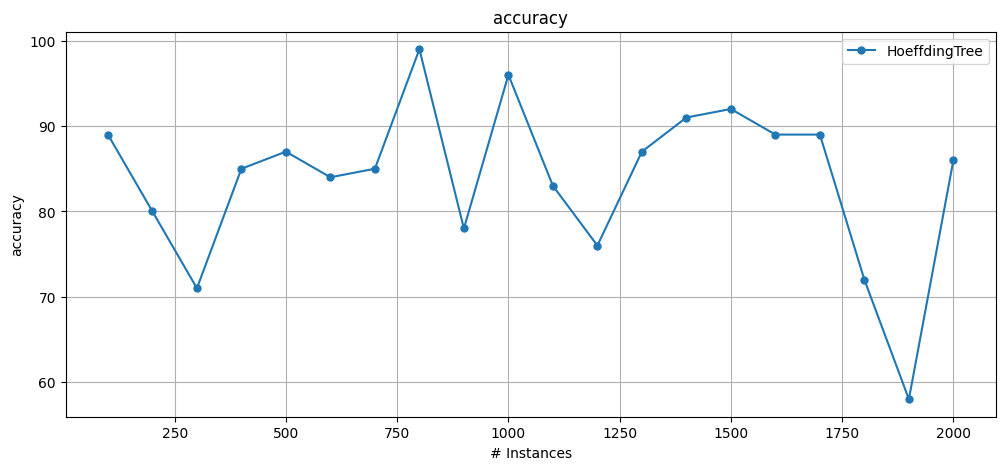

In [2]:
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import HoeffdingTree
from capymoa.datasets import ElectricityTiny
from capymoa.evaluation.visualization import plot_windowed_results

elec_stream = ElectricityTiny()
ht = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)

results_ht = prequential_evaluation(stream=elec_stream, learner=ht, window_size=100, optimise=True, store_predictions=False, store_y=False)


print("\tDifferent ways of accessing metrics:")

print(f"results_ht['wallclock']: {results_ht['wallclock']} results_ht.wallclock(): {results_ht.wallclock()}")
print(f"results_ht['cpu_time']: {results_ht['cpu_time']} results_ht.cpu_time(): {results_ht.cpu_time()}")

print(f"results_ht.cumulative.accuracy() = {results_ht.cumulative.accuracy()}")
print(f"results_ht.cumulative['accuracy'] = {results_ht.cumulative['accuracy']}")
print(f"results_ht['cumulative'].accuracy() = {results_ht['cumulative'].accuracy()}")
print(f"results_ht.accuracy() = {results_ht.accuracy()}")

print(f"\n\tAll the cumulative results:")
print(results_ht.cumulative.metrics_dict())

print(f"\n\tAll the windowed results:")
display(results_ht.metrics_per_window())
# OR display(results_ht.windowed.metrics_per_window())

# results_ht.write_to_file() -> this will save the results to a directory

plot_windowed_results(results_ht, metric= "accuracy")

### 2.4 Evaluating a single stream using multiple learners

```prequential_evaluation_multiple_learners()``` further encapsulates experiments by executing multiple learners on a single stream. 

* This function behaves as if we invoked ```prequential_evaluation()``` multiple times, but internally it only iterates through the Stream once. This is useful if we are faced with a situation where accessing each Instance of the Stream is costly this function will be more convenient than just invoking ```prequential_evaluation()``` multiple times. 

* This method does not calculate ```wallclock``` or ```cpu_time``` because the training and testing of each learner is interleaved, thus timing estimations are unreliable. Thus, the results dictionaries do not contain the keys ```wallclock``` and ```cpu_time```. 

OB final accuracy = 82.4174611581921 and ARF final accuracy = 89.32953742937853


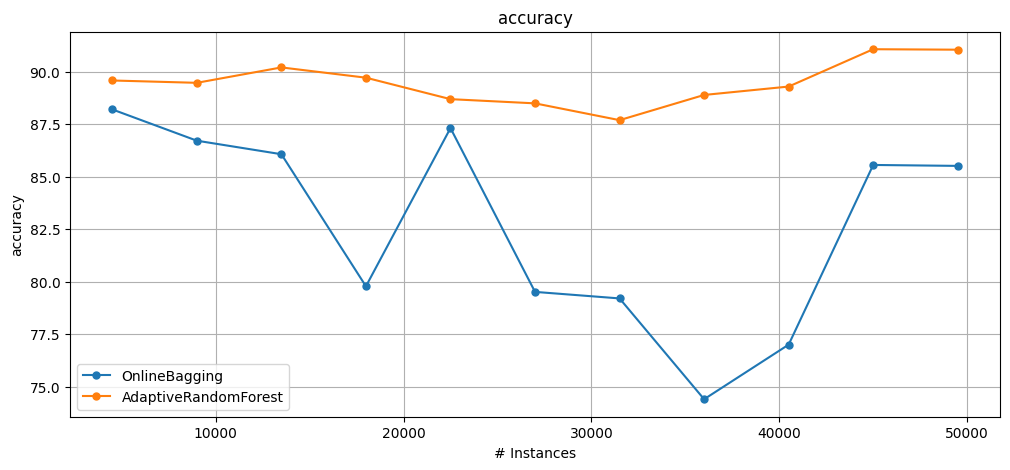

In [7]:
from capymoa.evaluation import prequential_evaluation_multiple_learners
from capymoa.datasets import Electricity
from capymoa.classifier import AdaptiveRandomForestClassifier, OnlineBagging
from capymoa.evaluation.visualization import plot_windowed_results

stream = Electricity()

# Define the learners + an alias (dictionary key)
learners = {
    'OB': OnlineBagging(schema=stream.get_schema(), ensemble_size=10),
    'ARF': AdaptiveRandomForestClassifier(schema=stream.get_schema(), ensemble_size=10)
}

results = prequential_evaluation_multiple_learners(stream, learners, window_size=4500)

print(f"OB final accuracy = {results['OB'].cumulative.accuracy()} and ARF final accuracy = {results['ARF'].cumulative.accuracy()}")
plot_windowed_results(results['OB'], results['ARF'], metric="accuracy")

## 3. Regression

* We introduce a simple example using regression just to show how similar it is to assess regressors using the **high-level evaluation functions**
* In the example below, we just use ```prequential_evaluation()``` but it would work with ```cumulative_evaluation()``` and ```windowed_evaluation()``` as well.
* One difference between Classification and Regression evaluation in CapyMOA is that the Evaluators are different. Instead of ```ClassificationEvaluator``` and ```ClassificationWindowedEvaluator``` functions use ```RegressionEvaluator``` and ```RegressionWindowedEvaluator```

kNNRegressor [cumulative] RMSE = 2.7229994765160916 and     AdaptiveRandomForestRegressor  [cumulative] RMSE = 2.3894271579519426


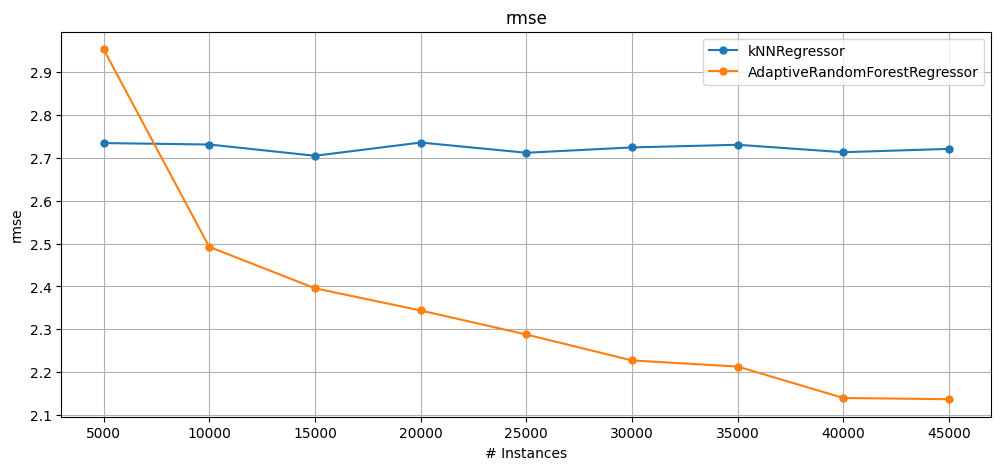

In [8]:
from capymoa.datasets import Fried
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation
from capymoa.regressor import KNNRegressor, AdaptiveRandomForestRegressor

stream = Fried()
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=10)

kNN_results = prequential_evaluation(stream=stream, learner=kNN_learner, window_size=5000)
ARF_results = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=5000)

print(f"{kNN_results['learner']} [cumulative] RMSE = {kNN_results['cumulative'].rmse()} and \
    {ARF_results['learner']}  [cumulative] RMSE = {ARF_results['cumulative'].rmse()}")

plot_windowed_results(kNN_results, ARF_results, metric='rmse')

### 3.1 Evaluating a single stream using multiple learners (Regression)

* ```prequential_evaluation_multiple_learners``` also works for multiple regressors, the example below shows how it can be used. 

Cumulative results for each learner:
kNNReg_k5, RMSE: 2.72, adjusted R2: 0.70
kNNReg_k2, RMSE: 3.08, adjusted R2: 0.62
kNNReg_k5_median, RMSE: 2.94, adjusted R2: 0.65
ARFReg_s5, RMSE: 2.58, adjusted R2: 0.73


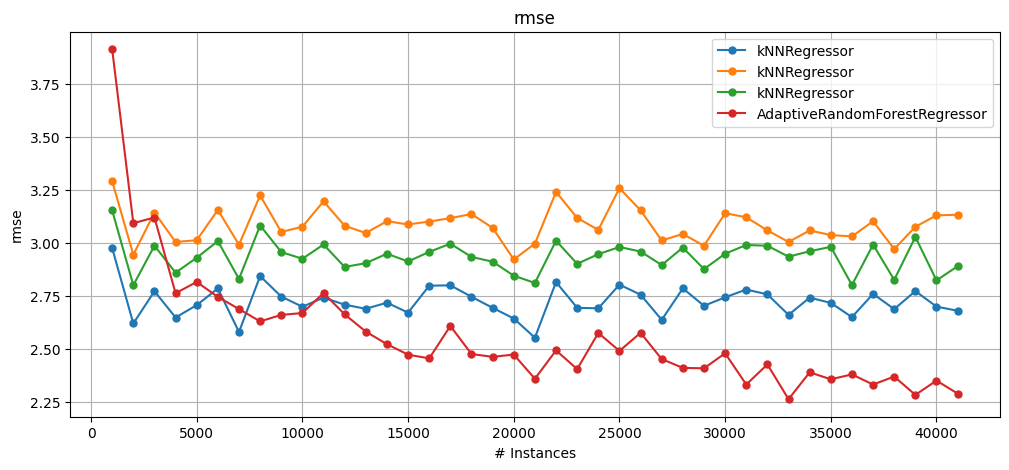

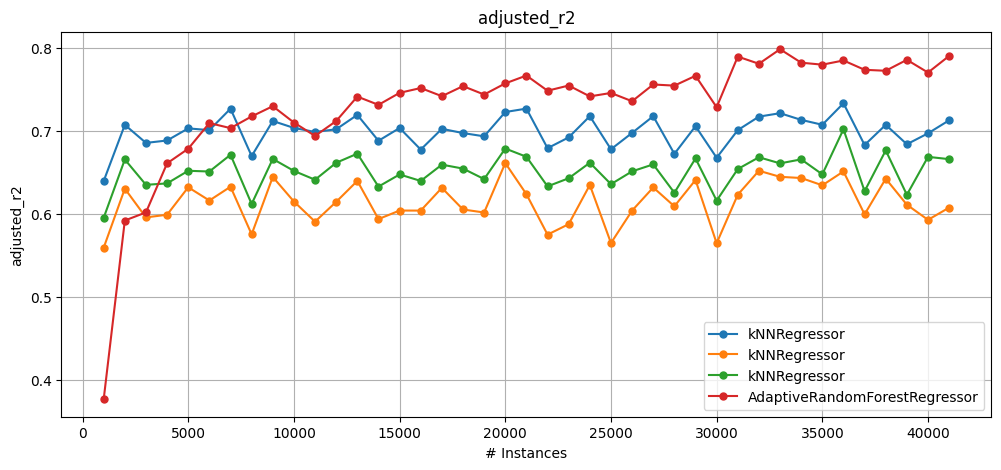

In [9]:
from capymoa.evaluation import prequential_evaluation_multiple_learners

# Define the learners + an alias (dictionary key)
learners = {
    'kNNReg_k5': KNNRegressor(schema=stream.get_schema(), k=5),
    'kNNReg_k2': KNNRegressor(schema=stream.get_schema(), k=2),
    'kNNReg_k5_median': KNNRegressor(schema=stream.get_schema(), CLI='-k 5 -m'),
    'ARFReg_s5': AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=5)
}

results = prequential_evaluation_multiple_learners(stream, learners)

print('Cumulative results for each learner:')
for learner_id in learners.keys():
    if learner_id in results:
        cumulative = results[learner_id]['cumulative']
        print(f"{learner_id}, RMSE: {cumulative.rmse():.2f}, adjusted R2: {cumulative.adjusted_r2():.2f}")

# Tip: invoking metrics_header() from an Evaluator will show us all the metrics available, 
# e.g. results['kNNReg_k5']['cumulative'].metrics_header()
plot_windowed_results(results['kNNReg_k5'], results['kNNReg_k2'], results['kNNReg_k5_median'], 
                      results['ARFReg_s5'], metric="rmse")

plot_windowed_results(results['kNNReg_k5'], results['kNNReg_k2'], results['kNNReg_k5_median'], 
                      results['ARFReg_s5'], metric="adjusted_r2")

### 3.2 Plotting predictions vs. ground truth over time (Regression)

* In Regression it is sometimes desirable to plot **predictions vs. ground truth** to observe what is happening with the Stream. If we create a custom loop and use the Evaluators directly it is trivial to store the ground truth and predictions, and then proceed to plot them. However, to make people's life easier ```plot_predictions_vs_ground_truth``` function can be used.

* For massive streams with millions of instances it can be unbearable to plot all at once, thus we can specify a ```plot_interval``` (that we want to investigate) to ```plot_predictions_vs_ground_truth```. By default, the plot function will attempt to plot everything, i.e. if ```plot_interval=None```, which is seldom a good idea. 

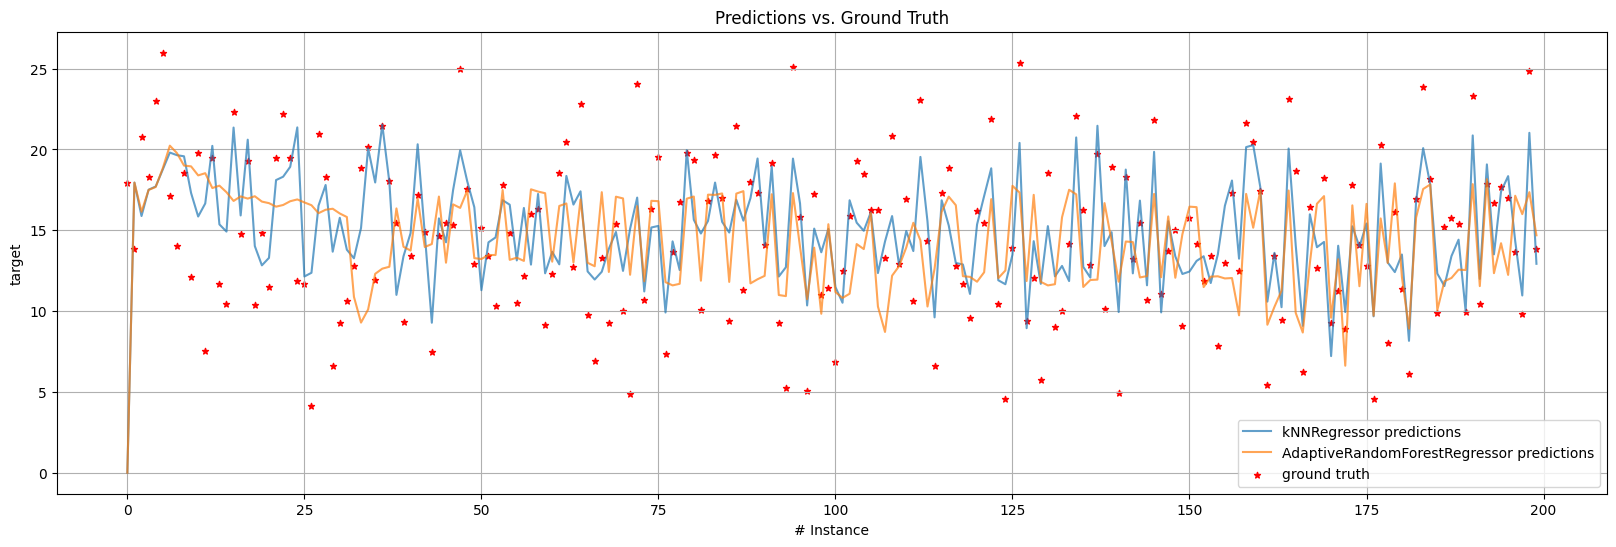

In [10]:
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_predictions_vs_ground_truth
from capymoa.regressor import KNNRegressor, AdaptiveRandomForestRegressor
from capymoa.datasets import Fried

stream = Fried()
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=10)

# When we specify store_predictions and store_y, the results will also include all the predictions and all the ground truth y. 
# It is useful for debugging and outputting the predictions elsewhere. 
kNN_results = prequential_evaluation(stream=stream, learner=kNN_learner, window_size=5000, store_predictions=True, store_y=True)
# We don't need to store the ground-truth for every experiment, since it is always the same for the same stream
ARF_results = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=5000, store_predictions=True)


# Plot only 200 predictions (see plot_interval)
plot_predictions_vs_ground_truth(kNN_results, ARF_results, ground_truth=kNN_results['ground_truth_y'], plot_interval=(0, 200))

# 8. Prediction Intervals for data streams

* How to utilise the prediction interval on regression tasks in CapyMOA
* Two methods for obtaining prediction intervals are currently available in CapyMOA: MVE and AdaPI
* 

More details about prediction intervals for streaming data can be found in the AdaPI paper: 

[Yibin Sun, Bernhard Pfahringer, Heitor Murilo Gomes & Albert Bifet. "Adaptive Prediction Interval for Data Stream Regression." Pacific-Asia Conference on Knowledge Discovery and Data Mining. Springer, 2024.](https://link.springer.com/chapter/10.1007/978-981-97-2259-4_10)


---

*More information about CapyMOA can be found in* https://www.capymoa.org

**notebook last updated on 25/07/2024**

In [1]:
from capymoa.datasets import Fried

# load data
fried_stream = Fried()

## 1. Basic prediction interval learner build-up

* An example of the use case of prediction interval in CapyMOA
* Current available prediction interval learners require a regressive base model to work

In [2]:
from capymoa.regressor import SOKNL
from capymoa.prediction_interval import MVE

# build prediction interval learner in regular manner
soknl = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
mve = MVE(schema=fried_stream.get_schema(), base_learner=soknl)

# build prediction interval learner in in-line manner
mve_inline = MVE(schema=fried_stream.get_schema(), base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10))

## 2. Creating evaluators

* We involve two types of prediction interval evaluators so far: basic (cumulative) and windowed

In [3]:
from capymoa.evaluation.evaluation import PredictionIntervalEvaluator, PredictionIntervalWindowedEvaluator
# build prediction interval (basic and windowed) evaluators
mve_evaluator = PredictionIntervalEvaluator(schema=fried_stream.get_schema())
mve_windowed_evaluator = PredictionIntervalWindowedEvaluator(schema=fried_stream.get_schema(), window_size=1000)

## 3. Running test-then-train/prequential tasks manually

**don't forget to train the models (call .train() function) at the end!**

In [4]:
# run test-then-train/prequential tasks
while fried_stream.has_more_instances():
    instance = fried_stream.next_instance()
    prediction = mve.predict(instance)
    mve_evaluator.update(instance.y_value, prediction)
    mve_windowed_evaluator.update(instance.y_value, prediction)
    mve.train(instance)

## 4. Results from both evaluators

In [5]:
# show results
print(f'MVE basic evaluation:\ncoverage: {mve_evaluator.coverage()}, NMPIW: {mve_evaluator.nmpiw()}')
print(f'MVE windowed evaluation in last window:\ncoverage: {mve_windowed_evaluator.coverage()}, NMPIW: {mve_windowed_evaluator.nmpiw()}')

MVE basic evaluation:
coverage: 97.28, NMPIW: 30.66
MVE windowed evaluation in last window:
coverage: [98.9, 98.1, 96.7, 97.7, 97.4, 97.7, 98.0, 97.8, 97.2, 96.8, 97.2, 97.9, 97.1, 97.5, 98.2, 97.8, 96.4, 97.4, 96.6, 97.3, 98.7, 96.4, 97.2, 97.0, 97.4, 96.0, 97.5, 97.1, 96.8, 96.7, 97.7, 97.2, 98.0, 96.1, 97.5, 97.2, 96.9, 97.2, 96.9, 96.7], NMPIW: [61.91, 46.44, 42.59, 43.82, 40.64, 40.08, 35.84, 38.32, 35.65, 39.25, 39.69, 36.09, 34.97, 34.95, 35.3, 34.79, 34.28, 33.46, 35.69, 35.64, 35.75, 35.03, 31.01, 33.91, 32.83, 33.54, 31.92, 31.31, 33.83, 32.07, 29.51, 33.25, 33.53, 31.93, 33.22, 29.3, 30.48, 29.39, 33.0, 32.14]


## 5. Wrap things up with prequential evaluation

* Prediction interval tasks also can be wrapped up with prequential evaluation in CapyMOA

In [6]:
from capymoa.evaluation import prequential_evaluation
from capymoa.prediction_interval import AdaPI

# restart stream
fried_stream.restart()
# specify regressive model
regressive_learner = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
# build prediction interval models
mve_learner = MVE(schema=fried_stream.get_schema(), base_learner=regressive_learner)
adapi_learner = AdaPI(schema=fried_stream.get_schema(), base_learner=regressive_learner, limit=0.001)
# gather results
mve_results = prequential_evaluation(stream=fried_stream, learner=mve_learner, window_size=1000)
adapi_results = prequential_evaluation(stream=fried_stream, learner=adapi_learner, window_size=1000)

# show overall results
print(f"MVE coverage: {mve_results.cumulative.coverage()}, NMPIW: {mve_results.cumulative.nmpiw()}")
print(f"AdaPI coverage: {adapi_results.cumulative.coverage()}, NMPIW: {adapi_results.cumulative.nmpiw()}")

MVE coverage: 97.28, NMPIW: 30.66
AdaPI coverage: 96.15, NMPIW: 28.53


## 6. Plots are also supported

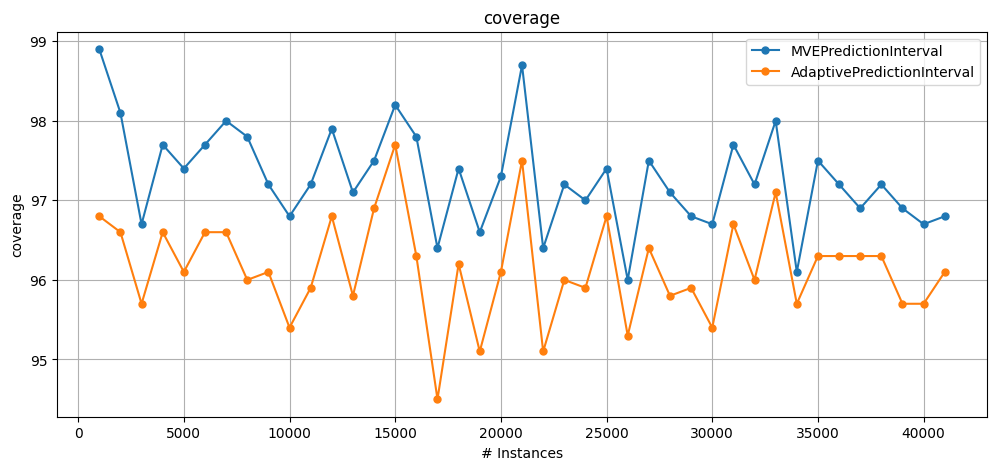

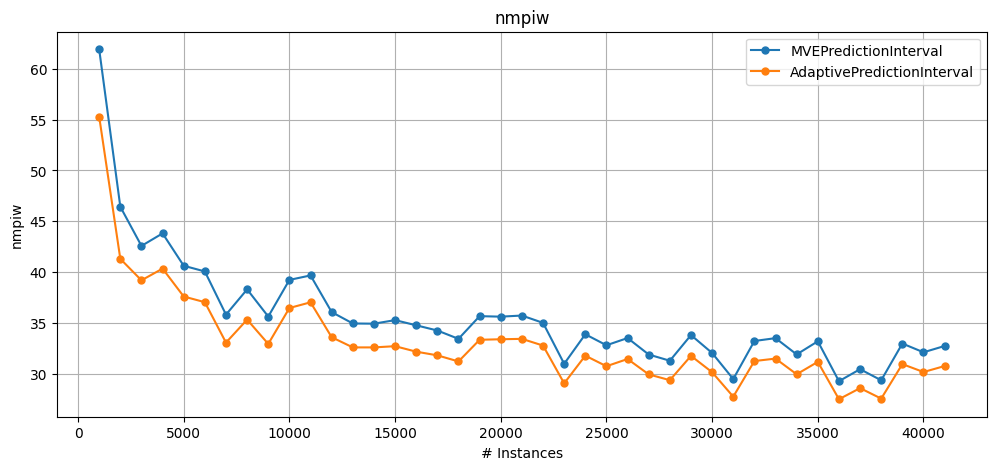

In [7]:
from capymoa.evaluation.visualization import plot_windowed_results
# plot over time comparison
plot_windowed_results(mve_results,adapi_results, metric='coverage')
plot_windowed_results(mve_results, adapi_results, metric='nmpiw')

### Plotting prediction intervals over time

* We should be able to plot prediction intervals from different learners against ground truths over time...
* This part is still under construction...

**Coming soon ;)**

# 4. Simulating Concept Drifts with the DriftStream API

This tutorial demonstrates how to use the DriftStream API in CapyMOA
* We start by showing how one can use a synthetic generator without concept drift (RandomTreeGenerator)
* We delve into the two API proposals for the DriftStream API, one of which has been implemented already
    * **DriftStream Position**: **```drift position``` + ```drift width```** (ready!)
    * **DriftStream Range**: **```concept num_instances``` + ```drift num_instances```** (_Under construction_)
* More advanced examples can be found in **Tutorial 6**: `Exploring Advanced Features`, such as configuring and manipulating MOA streams directly

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 27/07/2024**

## 1. CapyMOA synthetic generators

* In this example, we show how to use `RandomTreeGenerator` to generate a synthetic stream

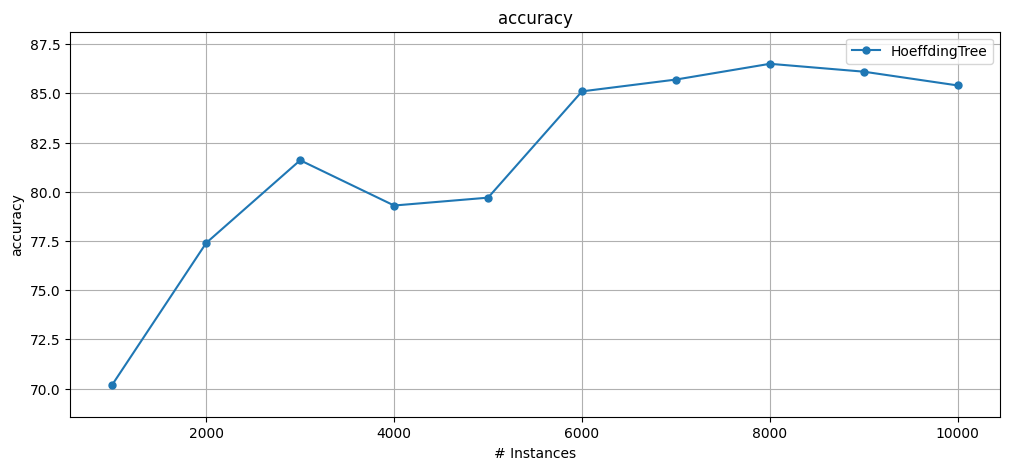

In [1]:
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import HoeffdingTree

rtg_stream = RandomTreeGenerator()

ht = HoeffdingTree(schema=rtg_stream.get_schema())

results_ht = prequential_evaluation(max_instances=10000, window_size=1000, stream=rtg_stream, learner=ht)

plot_windowed_results(results_ht, metric='accuracy')

## 2. CapyMOA DriftStream Builder API

* MOA uses a recursive approach to specify concept drift locations like ```CDS(CDS(SEA(1), SEA(2), 1000), SEA(3), 2000)``` where we specify the drift **position** and the **width** of a drift (if it is a Gradual Drift).

  
In CapyMOA, the concepts and drifts are clearly outlined on a list format. There are two ways of specifying a DriftStream in this list format:

1. **DriftStream Position**: **```drift position``` + ```drift width```**: the start and end of a concept is determined by the presence of an ```AbruptDrift``` or ```GradualDrift``` object.
   
  <!-- ```[SEA(1), AbruptDrift(position=1000), SEA(2), GradualDrift(position=2000, width=500), SEA(3)]``` -->
  
  **DriftStream([**<span style="color:blue;">SEA(1)</span>, <span style="color:red;">AbruptDrift(position=1000)</span>, <span style="color:blue;">SEA(2)</span>, <span style="color:green;">GradualDrift(<b>position</b>=2000, <b>width</b>=500)</span>, <span style="color:blue;">SEA(3)</span>**])**

  The ```GradualDrift``` can also be specified in terms of ```start``` and ```end```.
  
  <!-- ```[SEA(1), AbruptDrift(position=1000), SEA(2), GradualDrift(start=1750, end=2250), SEA(3)]``` -->
  **DriftStream([**<span style="color:blue;">SEA(1)</span>, <span style="color:red;">AbruptDrift(position=1000)</span>, <span style="color:blue;">SEA(2)</span>, <span style="color:green;">GradualDrift(<b>start</b>=1750, <b>end</b>=2250)</span>, <span style="color:blue;">SEA(3)</span>**])**


2. **DriftStream Range**: **```concept num_instances``` + ```drift num_instances```**: the start and end of a concept is determined by the amount of instances generated for it, the same thing can be said about ```GradualDrifts``` which do not have a ```start``` or ```end``` but the number of instances i.e. the ```width``` of that drifting region (or drifting window). Notice that we must prevent users from specifying a drift ```position``` or drift ```start``` and ```end``` when using this version because that would be confusing and error prone. The reason is that the specification of the DriftStream, in this version, doesn't explicitly tells us about the locations of the drifts on the stream, so it is less error prone if we don't allow the user to use this approach mixed with the ```drift position``` one. Example:
   
    <!-- ```[Concept(SEA(1), num_instances=1000), AbruptDrift(), Concept(SEA(2), num_instances=500), GradualDrift(num_instances=500), Concept(SEA(3), num_instances=500)]``` -->
    **DriftStream([**<span style="color:blue;"><b>Concept(</b>SEA(1), num_instances=1000<b>)</b></span>, <span style="color:red;">AbruptDrift()</span>, <span style="color:blue;"><b>Concept(</b>SEA(2), num_instances=500<b>)</b></span>, <span style="color:green;">GradualDrift(num_instances=500)</span>, <span style="color:blue;"><b>Concept(</b>SEA(3), num_instances=500<b>)</b></span>**])**


* Why do we need the **```Concept()```** specification in the **```num_instances```**? The **Stream** class, i.e. base class for **SEA** and other synthetic generators do not implement the concept of a ```max_instances``` or ```num_instances```. If we were to implement that, we would lose compatibility with MOA (where such constraints doesn't exist) and would need to do some extra checks when generating streams. 
* The **```DriftStream```** specification in the ```position``` + ```width``` version does not specify the total ```size``` of the stream, i.e. notice how the SEA(3) at the end is unbounded, there is no Drift object signaling its end. That is intentional, the user specifying the DriftStream and manipulating it defines the end of the Stream externally. This is true for synthetic streams and also for limiting *snapshot* streams like **electricity** and others that are read from files. 


### 2.1 DriftStream prelude: the raw MOA version

* We first show how it is done using MOA's API, so that one can compare it with CapyMOA syntax
* We simulate the following drifting stream using a traditional recursive MOA syntax

```sh
SEA(function=1), Drift(position=5000, width=1000), SEA(function=2), Drift(position=10000, width=2000), SEA(function=3)
```

* The CLI below is _easy_ to configure in the MOA GUI, but it can lead to issues when specified directly on the CLI

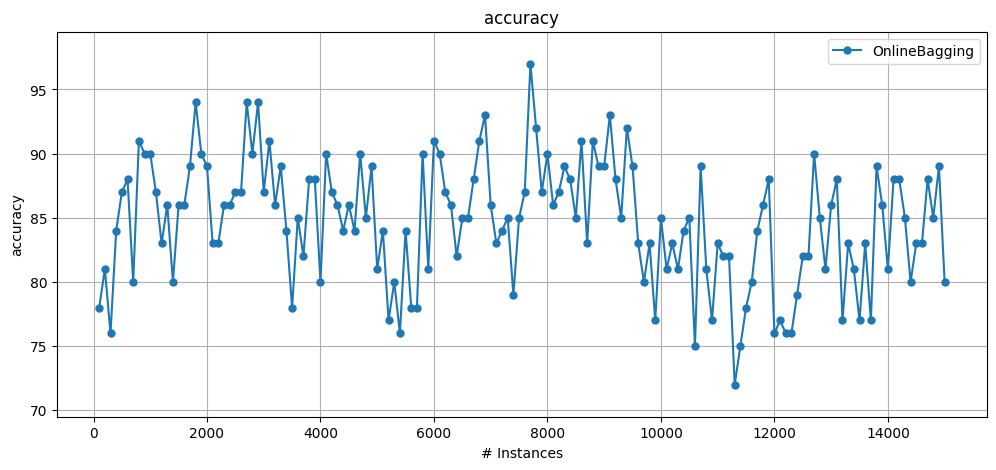

In [2]:
from capymoa.classifier import OnlineBagging
from capymoa.stream import Stream
from moa.streams import ConceptDriftStream

stream_sea2drift = Stream(moa_stream=ConceptDriftStream(), 
    CLI="-s (ConceptDriftStream -s (generators.SEAGenerator -f 1) -d (generators.SEAGenerator -f 2) -p 5000 -w 1) -d (generators.SEAGenerator -f 3) -p 10000 -w 2000")

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000)

plot_windowed_results(results_sea2drift_OB, metric='accuracy')

### 2.2 DriftStream ```position``` + ```width```

* Specifying drift location using the *first* version.
* We can use either position + width or start + end to define GradualDrifts in this approach.

  ```sh
  GradualDrift(position=10000, width=2000)
  ```
  or
  ```sh
  GradualDrift(start=9000, end=12000)
  ```
* **Important**: meta-data about the specified Drifts is accessible from the stream object

```python
print(f'The definition of the DriftStream is accessible through the object:\n {stream_sea2drift}')
```

* Furthermore, this meta-data is interpreted by the `plot_windowed_results` function producing plots that automatically indicates drift locations. 

The definition of the DriftStream is accessible through the object:
 SEA(function=1),AbruptDrift(position=5000),SEA(function=3),GradualDrift(position=10000, start=9000, end=11000, width=2000),SEA(function=1)


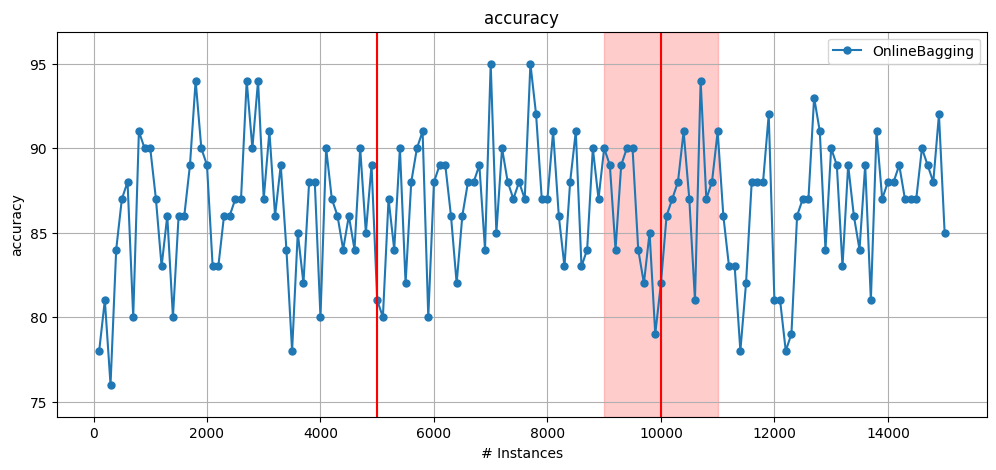

In [3]:
from capymoa.stream.drift import DriftStream, Drift, AbruptDrift, GradualDrift
from capymoa.stream.generator import SEA

stream_sea2drift = DriftStream(stream=[SEA(function=1), 
                                AbruptDrift(position=5000), 
                                SEA(function=3), 
                                GradualDrift(position=10000, width=2000), 
                                # GradualDrift(start=9000, end=12000),
                                SEA(function=1)])

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000)

print(f'The definition of the DriftStream is accessible through the object:\n {stream_sea2drift}')
plot_windowed_results(results_sea2drift_OB, metric='accuracy')

#### 2.2.1 Obtaining meta-data about drift from a MOA Stream

* Besides composing a drifting stream, the DriftStream object also holds information about the Drifts. 
* The meta-data about the drifts can be used for quickly investigating where and how many `Drifts` a particular `Stream` object has associated with it.

* It is doable to extract drifting information from the MOA ConceptDriftStream objects, precisely the Stream objects that form the concepts for a proper printing. However, that has not been implemented yet as it is a bit cumbersome. So, for the moment, when a DriftStream is specified based on a MOA CLI, we just return the CLI used when we attempt to print the object (see below)

```python
print(stream_sea2drift)
```

* However, the information is available and can be accessed through the `get_drifts()` method as we exemplify below

```python
for drift in stream_sea2drift.get_drifts():
    print(f'\t{drift}')
```

Attempting to print a stream from a raw MOA ConceptDriftStream: ConceptDriftStream -s (ConceptDriftStream -s generators.SEAGenerator -d (generators.SEAGenerator -f 3) -p 5000 -w 1)                                -d generators.SEAGenerator -w 200 -p 10000 -r 1 -a 0.0

Now, an example on how to access individual drifts from a DriftStream:
	AbruptDrift(position=5000)
	GradualDrift(position=10000, width=200)


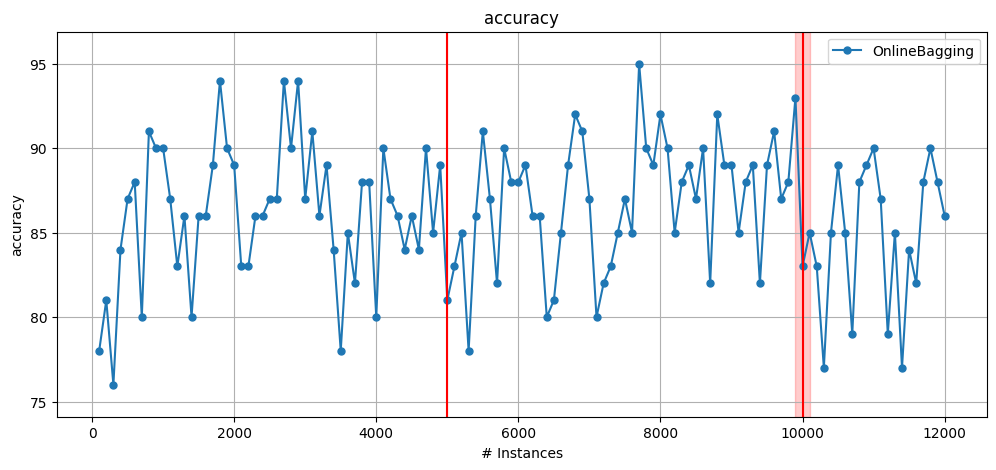

In [4]:
from moa.streams import ConceptDriftStream

stream_sea2drift = DriftStream(moa_stream=ConceptDriftStream(), 
                               CLI='-s (ConceptDriftStream -s generators.SEAGenerator -d (generators.SEAGenerator -f 3) -p 5000 -w 1) \
                               -d generators.SEAGenerator -w 200 -p 10000 -r 1 -a 0.0')

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=12000)

print(f'Attempting to print a stream from a raw MOA ConceptDriftStream: {stream_sea2drift}')
print('\nNow, an example on how to access individual drifts from a DriftStream:')
for drift in stream_sea2drift.get_drifts():
    print(f'\t{drift}')
# Notice it works just fine to plot and use the DriftStream created using a MOA object. 
plot_windowed_results(results_sea2drift_OB, metric='accuracy')

## 2.3 DriftStream ```range``` 

* This version of the DriftStream builder uses the concept of specfying the number of instances in each concept and drift, i.e. ```concept num_instances``` and ```drift num_instances```

* Still under development! Come back later :)
<div style="text-align:center">
  <img src="under_construction.jpeg" alt="alt text" width="300" height="300">
</div>


## 2.4 RecurrentConceptDriftStream 

### 2.4.1 Generate a stream with recurrent concepts.  

Recurrent concept stream CapyMOA:
RTG(),AbruptDrift(position=2000),RTG(tree_random_seed=2),AbruptDrift(position=4000),RTG(tree_random_seed=3),AbruptDrift(position=6000),RTG(instance_random_seed=2),AbruptDrift(position=8000),RTG(instance_random_seed=2, tree_random_seed=2),AbruptDrift(position=10000),RTG(instance_random_seed=2, tree_random_seed=3)
Recurrent concept stream MOA CLI: 
 -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -d (generators.RandomTreeGenerator -r 2) -p 2000 -w 0) -d (generators.RandomTreeGenerator -r 3) -p 4000 -w 0) -d (generators.RandomTreeGenerator -i 2) -p 6000 -w 0) -d (generators.RandomTreeGenerator -r 2 -i 2) -p 8000 -w 0)  -d (generators.RandomTreeGenerator -r 3 -i 2) -w 0 -p 10000 -r 1 -a 0.0


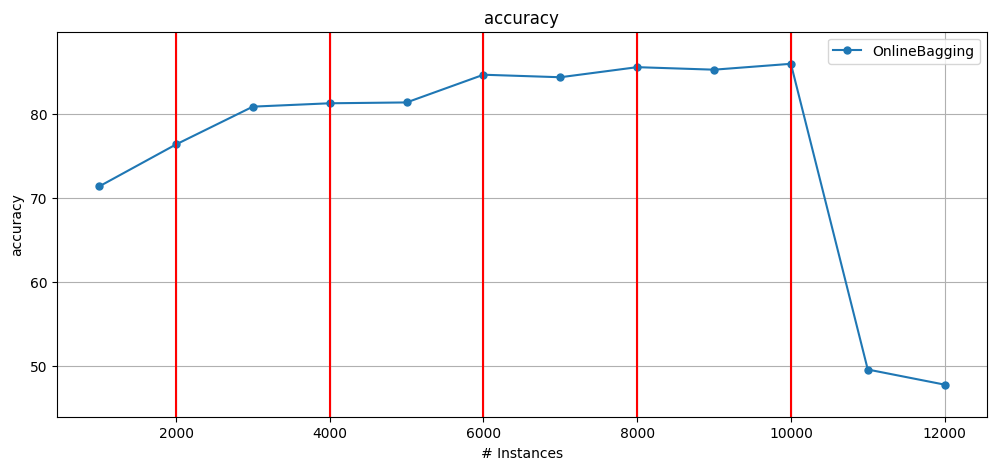

In [5]:
from capymoa.stream.drift import DriftStream, AbruptDrift
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

window_size = 1000
concept_length = 2000
max_instances = concept_length*6

stream_with_drifts = DriftStream(stream=[
                                RandomTreeGenerator(tree_random_seed=1), AbruptDrift(position=concept_length*1),
                                RandomTreeGenerator(tree_random_seed=2), AbruptDrift(position=concept_length*2),
                                RandomTreeGenerator(tree_random_seed=3), AbruptDrift(position=concept_length*3),
                                RandomTreeGenerator(tree_random_seed=1, instance_random_seed=2), AbruptDrift(position=concept_length*4),
                                RandomTreeGenerator(tree_random_seed=2, instance_random_seed=2), AbruptDrift(position=concept_length*5),
                                RandomTreeGenerator(tree_random_seed=3, instance_random_seed=2),
                                ])


OB = OnlineBagging(schema=stream_with_drifts.get_schema(), ensemble_size=10)

results_stream_with_drifts_OB = prequential_evaluation(stream=stream_with_drifts, learner=OB, window_size=window_size, max_instances=max_instances)

print(f'Recurrent concept stream CapyMOA:\n{stream_with_drifts}')
print(f'Recurrent concept stream MOA CLI: \n{stream_with_drifts._CLI}')
plot_windowed_results(results_stream_with_drifts_OB, metric='accuracy')

###  2.4.2 Use recurrent concept drift API to generate recurrent concepts.
* The API adds concept meta information for plotting which is not available in the previous example. 

Recurrent concept stream CapyMOA:
RTG(),AbruptDrift(position=2000),RTG(tree_random_seed=2),AbruptDrift(position=4000),RTG(tree_random_seed=3),AbruptDrift(position=6000),RTG(instance_random_seed=2),AbruptDrift(position=8000),RTG(instance_random_seed=2, tree_random_seed=2),AbruptDrift(position=10000),RTG(instance_random_seed=2, tree_random_seed=3)
Recurrent concept stream MOA CLI: 
 -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -d (generators.RandomTreeGenerator -r 2) -p 2000 -w 0) -d (generators.RandomTreeGenerator -r 3) -p 4000 -w 0) -d (generators.RandomTreeGenerator -i 2) -p 6000 -w 0) -d (generators.RandomTreeGenerator -r 2 -i 2) -p 8000 -w 0)  -d (generators.RandomTreeGenerator -r 3 -i 2) -w 0 -p 10000 -r 1 -a 0.0


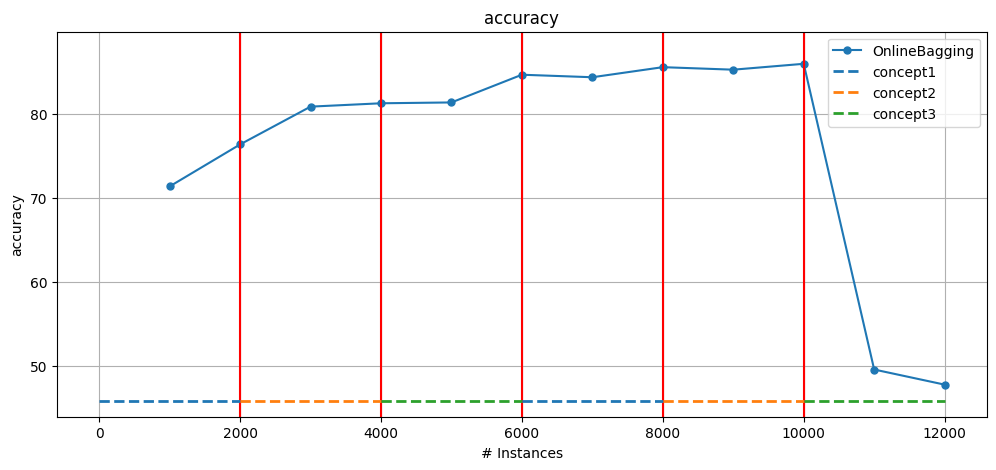

In [6]:
from capymoa.stream.drift import AbruptDrift, RecurrentConceptDriftStream
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results  

concept1 = RandomTreeGenerator(tree_random_seed=1, instance_random_seed=1)
concept2 = RandomTreeGenerator(tree_random_seed=2, instance_random_seed=1)
concept3 = RandomTreeGenerator(tree_random_seed=3, instance_random_seed=1)


window_size = 1000
concept_length = 2000
concept_list = [concept1, concept2, concept3]
concept_name_list = ['concept1', 'concept2', 'concept3']
max_recurrences_per_concept = 2
max_instances = concept_length * len(concept_list) * max_recurrences_per_concept

stream_with_recurrent_concepts = RecurrentConceptDriftStream(concept_list=concept_list,
                                               max_recurrences_per_concept=max_recurrences_per_concept,
                                               transition_type_template=AbruptDrift(position=concept_length),
                                               concept_name_list=concept_name_list
                                               )

OB = OnlineBagging(schema=stream_with_recurrent_concepts.get_schema(), ensemble_size=10)

results_stream_with_drifts_OB = prequential_evaluation(stream=stream_with_recurrent_concepts, learner=OB, window_size=window_size, max_instances=max_instances)

print(f'Recurrent concept stream CapyMOA:\n{stream_with_recurrent_concepts}')
print(f'Recurrent concept stream MOA CLI: \n{stream_with_recurrent_concepts._CLI}')

plot_windowed_results(results_stream_with_drifts_OB, metric='accuracy')


# Drift Detection in CapyMOA

In this tutorial, we show how to conduct drift detection using CapyMOA

* Then test different drift detectors
* Example using ADWIN
* Evaluating detectors based on known drift location

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 25/07/2024**

In [1]:
import numpy as np
import pandas as pd

import capymoa.drift.detectors as detectors

## Basic example

- Creating dummy data

In [2]:
data_stream = np.random.randint(2, size=2000)
for i in range(999, 2000):
    data_stream[i] = np.random.randint(6, high=12)

- Basic drift detection example

In [3]:
all_detectors = detectors.__all__

n_detections = {k: 0 for k in all_detectors}
for detector_name in all_detectors:

    detector = getattr(detectors, detector_name)()

    for i in range(2000):
        detector.add_element(float(data_stream[i]))
        if detector.detected_change():
            n_detections[detector_name] += 1

print(pd.Series(n_detections))

ADWIN                       1
CUSUM                       2
DDM                         1
EWMAChart                   1
GeometricMovingAverage      1
HDDMAverage               154
HDDMWeighted               92
PageHinkley                 2
RDDM                        1
SEED                        3
STEPD                       1
dtype: int64


## Example using ADWIN

In [4]:
from capymoa.drift.detectors import ADWIN

detector = ADWIN(delta=0.001)

for i in range(2000):
    detector.add_element(data_stream[i])
    if detector.detected_change():
        print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))


Change detected in data: 10 - at index: 1023


In [5]:
# Detection indices
detector.detection_index

[1024]

In [6]:
# Warning indices
detector.warning_index

[]

In [7]:
# Instance counter
detector.idx

2000

## Evaluating drift detectors

Assuming the drift locations are known, you can evaluate detectors using **EvaluateDetector** class

This class takes a parameter called **max_delay**, which is the maximum number of instances for which we consider a detector to have detected a change. After **max_delay** instances, we assume that the change is obvious and have been missed by the detector.

In [8]:
from capymoa.drift.eval_detector import EvaluateDetector

In [9]:
eval = EvaluateDetector(max_delay=200)

The EvaluateDetector class takes two arguments for evaluating detectors:
- The locations of the drift
- The locations of the detections

In [10]:
trues = np.array([1000])
preds = detector.detection_index

eval.calc_performance(preds, trues)

mean_time_to_detect           24.0
missed_detection_ratio         0.0
mean_time_btw_false_alarms     NaN
no_alarms_per_episode          0.0
dtype: float64

# Clustering tutorial 

In [1]:
from capymoa.base import MOAClusterer
from capymoa.stream.generator import RandomRBFGeneratorDrift
from moa.clusterers.clustream import Clustream
from capymoa.evaluation.visualization import plot_clustering_state

## 1. Getting started example

- Here we use only a stream and a clusterer
- We implement the loop manually
- We use a visualization function to print the clustering state

In [2]:
stream = RandomRBFGeneratorDrift(number_of_attributes=2, number_of_centroids=10, number_of_drifting_centroids=1, magnitude_of_change=0.001)
clustream = MOAClusterer(schema=stream.get_schema(), moa_learner=Clustream, CLI="-k 10")

Processed 100 instances.


/Users/gwcassales/Documents/CapyMOA/src/capymoa/evaluation/visualization.py:884: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Processed 200 instances.
Processed 300 instances.


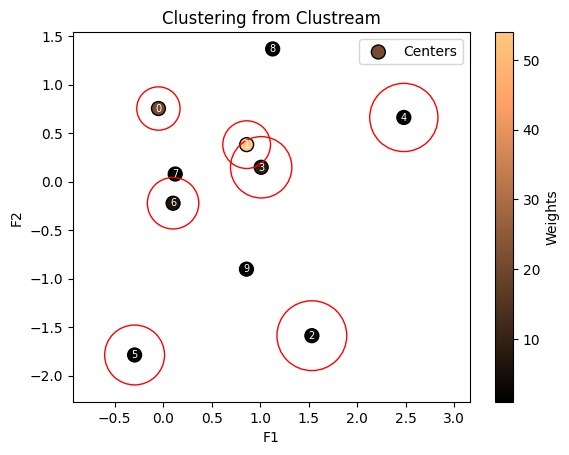

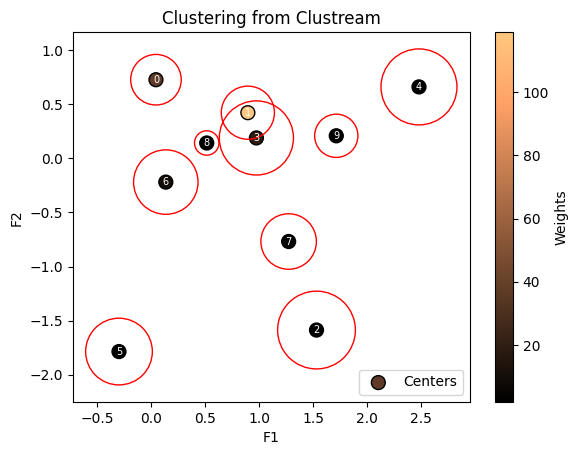

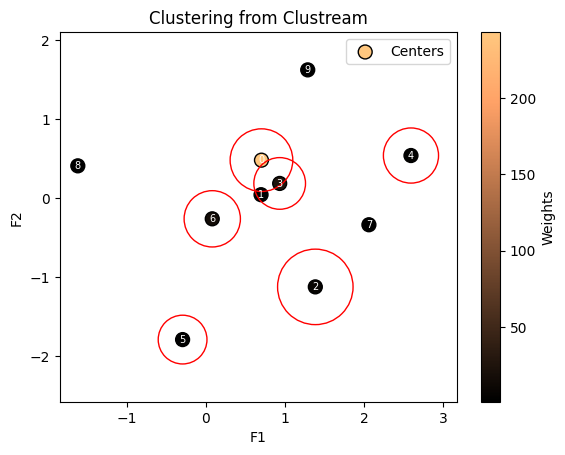

In [3]:
instancesSeen = 0
updateInterval = 100
while stream.has_more_instances() and instancesSeen < 300:
    instance = stream.next_instance()
    clustream.train(instance)
    instancesSeen += 1
    if instancesSeen % updateInterval == 0:
        print(f"Processed {instancesSeen} instances.")
        plot_clustering_state(clustream)
        # by default, plot_clustering_state only shows the image and does not save it

## 2. Using the Clustering Evaluator


In [4]:
from capymoa.evaluation import ClusteringEvaluator

In [5]:
stream = RandomRBFGeneratorDrift(number_of_attributes=2, number_of_centroids=10, number_of_drifting_centroids=1, magnitude_of_change=0.001)
clustream = MOAClusterer(schema=stream.get_schema(), moa_learner=Clustream, CLI="-k 10")
evaluator = ClusteringEvaluator(update_interval=50)

### 2.1 It is still possible to plot the clustering state of a clusterer on demand

In [6]:
while stream.has_more_instances() and evaluator.get_instances_seen() < 1000:
    instance = stream.next_instance()
    clustream.train(instance)
    evaluator.update(clustream)
    instancesSeen = evaluator.get_instances_seen()
    # purposefully arbitrary number
    if instancesSeen == 157:
        # can also skip show and only save
        print(f"Processed {instancesSeen} instances. Saving the figure without showing it.")
        plot_clustering_state(clustream, show_fig=False, save_fig=True, figure_name='save_fig_dont_show')


Processed 157 instances. Saving the figure without showing it.


### 2.2 Alternatively,  it is possible to plot the evaluation results as a whole, generating a gif

- Passing `clean_up=False` to the `plot_clustering_evolution` function will keep the intermediate figures used to create the gif.


In [7]:
from capymoa.evaluation.visualization import plot_clustering_evolution
plot_clustering_evolution(evaluator, clean_up=True)

# Semi-supervised Learning

* Preparing and executing partially and delayed labeling experiments

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**notebook last updated on 25/07/2024**

In [1]:
from capymoa.stream import stream_from_file
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_ssl_evaluation
from capymoa.datasets import Electricity

## 1. Learning using a SSL classifier

* This example uses the OSNN algorithm to learn from a stream with only 1% labeled data
* We utilize the `prequential_ssl_evaluation()` function to simulate the absence of labels (`label_probability`) and delays (`delay_length`)
* The results yield by `prequential_ssl_evaluation()` include more information in comparison to `prequential_evaluation()`, such as the number of unlabeled instances (`unlabeled`) and the unlabeled ratio (`unlabeled_ratio`). 

In [2]:
help(prequential_ssl_evaluation)

Help on function prequential_ssl_evaluation in module capymoa.evaluation.evaluation:

prequential_ssl_evaluation(stream, learner, max_instances=None, window_size=1000, initial_window_size=0, delay_length=0, label_probability=0.01, random_seed=1, store_predictions=False, store_y=False, optimise=True)
    If the learner is not an SSL learner, then it will be trained only on the labeled instances.



59.3


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,100.0,34.0,0.000000,-340.000000,-112.903226,NaN,50.746269,NaN,NaN,34.000000,NaN,50.000000,100.000000,0.000000
1,200.0,65.0,0.000000,-150.000000,41.666667,NaN,78.787879,NaN,NaN,65.000000,NaN,50.000000,100.000000,0.000000
2,300.0,62.0,-23.136747,-216.666667,-2.702703,38.271605,NaN,76.543210,37.349398,0.000000,74.698795,39.240506,0.000000,78.481013
3,400.0,63.0,3.242678,-236.363636,44.776119,62.922136,77.018634,5.128205,81.313131,62.626263,100.000000,51.315789,100.000000,2.631579
4,500.0,45.0,-4.009077,-358.333333,-5.769231,31.034483,62.068966,NaN,22.959184,45.918367,0.000000,47.872340,95.744681,0.000000
5,600.0,47.0,6.952247,-278.571429,-51.428571,55.070599,54.700855,36.144578,55.967450,40.506329,71.428571,54.202037,84.210526,24.193548
6,700.0,57.0,2.890696,-138.888889,14.000000,51.548932,68.613139,31.746032,51.754386,61.842105,41.666667,51.345103,77.049180,25.641026
7,800.0,78.0,54.337900,-29.411765,48.837209,77.384628,81.666667,72.500000,78.078078,77.777778,78.378378,76.703386,85.964912,67.441860
8,900.0,58.0,17.808219,-121.052632,22.222222,59.376801,55.319149,60.377358,59.562842,66.666667,52.459016,59.191919,47.272727,71.111111
9,1000.0,84.0,67.793881,-100.000000,68.000000,83.896940,85.185185,82.608696,83.896940,85.185185,82.608696,83.896940,85.185185,82.608696


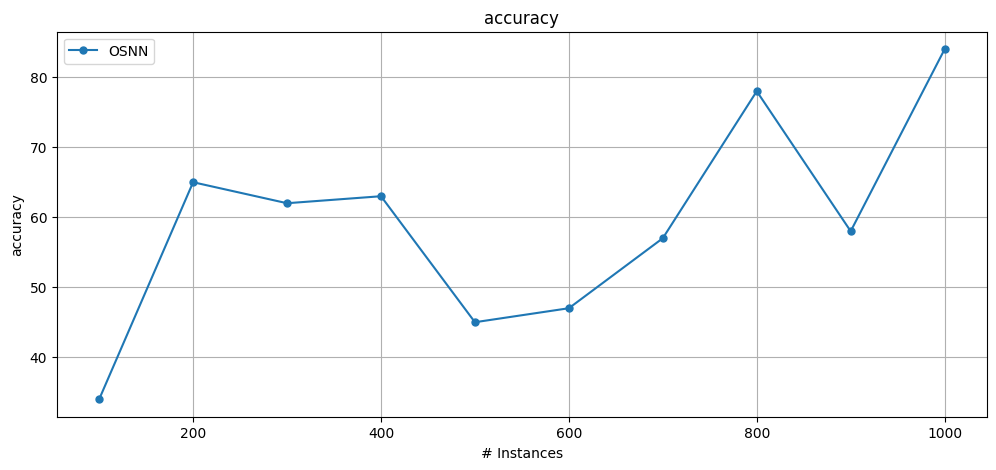

In [3]:
from capymoa.ssl.classifier import OSNN

stream = Electricity()

osnn = OSNN(schema=stream.get_schema())

results_osnn = prequential_ssl_evaluation(stream=stream, learner=osnn, label_probability=0.01, window_size=100, max_instances=1000)

# The results are stored in a dictionary. 
display(results_osnn)

print(results_osnn['cumulative'].accuracy()) # Test-then-train accuracy, i.e. cumulatively, not windowed. 
display(results_osnn['windowed'].metrics_per_window()) # A dataframe containing the windowed results. 

# Plotting over time (default: classifications correct (percent) i.e. accuracy)
results_osnn.learner = "OSNN"
plot_windowed_results(results_osnn, metric='accuracy')

## 1.1 Using a supervised model

* If a supervised model is used with `prequential_ssl_evaluation()` it will only be trained on the labeled data



In [4]:
from capymoa.classifier import StreamingRandomPatches

srp10 = StreamingRandomPatches(schema=stream.get_schema(), ensemble_size=10)

results_srp10 = prequential_ssl_evaluation(stream=stream, learner=srp10, label_probability=0.01, window_size=100, max_instances=1000)

print(results_srp10['cumulative'].accuracy())
display(results_srp10['windowed'].metrics_per_window())

47.199999999999996


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,100.0,34.0,0.000000,-340.000000,-112.903226,NaN,50.746269,NaN,NaN,34.000000,NaN,50.000000,100.000000,0.000000
1,200.0,65.0,0.000000,-150.000000,41.666667,NaN,78.787879,NaN,NaN,65.000000,NaN,50.000000,100.000000,0.000000
2,300.0,21.0,0.000000,-558.333333,-113.513514,NaN,34.710744,NaN,NaN,21.000000,NaN,50.000000,100.000000,0.000000
3,400.0,62.0,0.000000,-245.454545,43.283582,NaN,76.543210,NaN,NaN,62.000000,NaN,50.000000,100.000000,0.000000
4,500.0,50.0,5.338887,-316.666667,3.846154,61.726883,65.277778,10.714286,74.226804,48.453608,100.000000,52.830189,100.000000,5.660377
5,600.0,38.0,-7.489598,-342.857143,-77.142857,44.007051,48.333333,22.500000,42.682927,35.365854,50.000000,45.415959,76.315789,14.516129
6,700.0,26.0,-39.992433,-311.111111,-48.000000,27.554157,24.489796,27.450980,27.327327,32.432432,22.222222,27.784784,19.672131,35.897436
7,800.0,62.0,13.043478,-123.529412,11.627907,65.753425,75.000000,20.833333,80.000000,60.000000,100.000000,55.813953,100.000000,11.627907
8,900.0,59.0,10.480349,-115.789474,24.074074,60.034800,72.108844,22.641509,66.304348,57.608696,75.000000,54.848485,96.363636,13.333333
9,1000.0,55.0,2.343750,-462.500000,10.000000,61.508853,70.588235,4.255319,77.272727,54.545455,100.000000,51.086957,100.000000,2.173913


## 1.2 Comparing a SSL and supervised classifiers

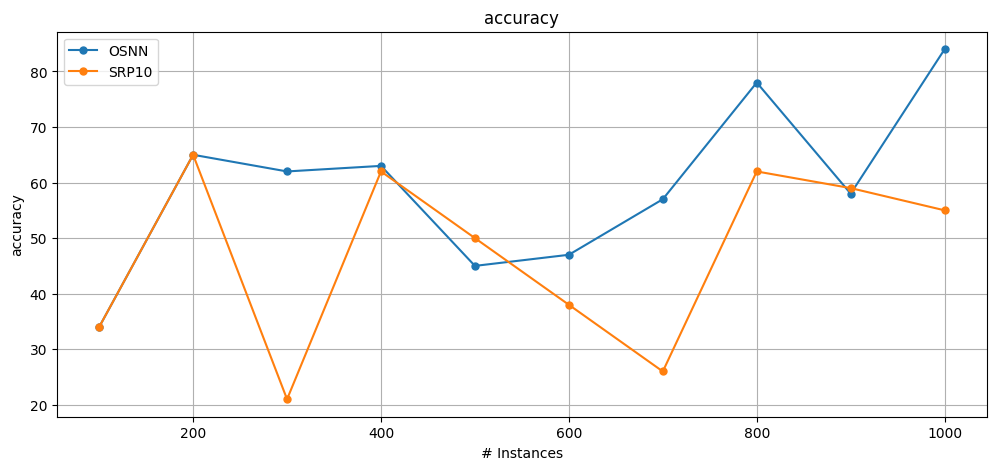

In [5]:
# Plotting all the results together
# Adding an experiment_id to the results dictionary allows controlling the legend of each learner. 
results_osnn.learner = 'OSNN'
results_srp10.learner = 'SRP10'

plot_windowed_results(results_osnn, results_srp10, metric='accuracy')

## 2. Delay example
* Comparing the effect of delay on a stream
* It is particularly interesting to see the effect after a drift takes place. 

Accuracy immediate: 86.031
Accuracy delayed by 1000 instances: 82.865


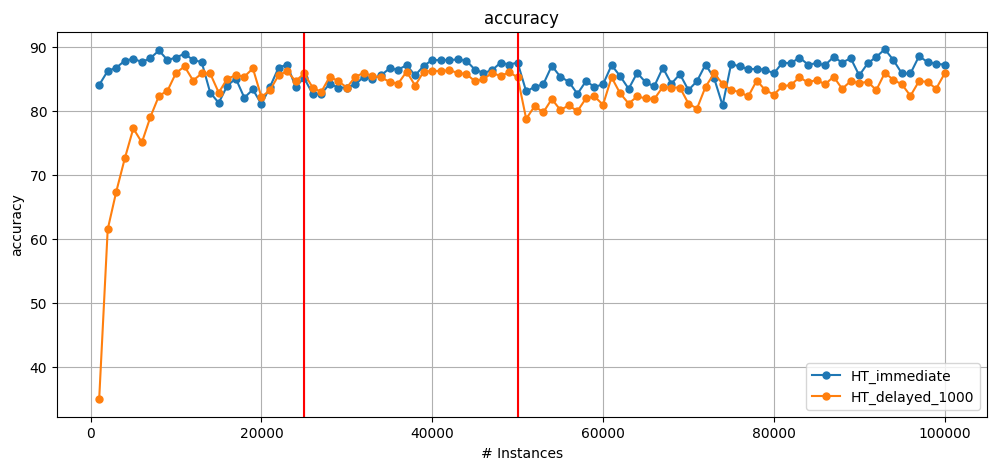

In [6]:
from capymoa.stream.generator import SEA
from capymoa.stream.drift import *
from capymoa.classifier import HoeffdingTree
from capymoa.evaluation import prequential_evaluation

## Creating a stream with drift
sea2drifts = DriftStream(stream=[SEA(function=1), 
                                 AbruptDrift(position=25000), 
                                 SEA(function=2), 
                                 AbruptDrift(position=50000), 
                                 SEA(function=3)])


ht_immediate = HoeffdingTree(schema=sea2drifts.get_schema())
ht_delayed = HoeffdingTree(schema=sea2drifts.get_schema())

results_ht_immediate = prequential_ssl_evaluation(stream=sea2drifts, 
                                                     learner=ht_immediate, 
                                                     label_probability=0.1, 
                                                     window_size=1000, 
                                                     max_instances=100000)

results_ht_delayed_1000 = prequential_ssl_evaluation(stream=sea2drifts, 
                                                       learner=ht_delayed, 
                                                       label_probability=0.01, 
                                                       delay_length=1000, # adding the delay
                                                       window_size=1000, 
                                                       max_instances=100000)

results_ht_immediate.learner = 'HT_immediate'
results_ht_delayed_1000.learner = 'HT_delayed_1000'

print(f"Accuracy immediate: {results_ht_immediate['cumulative'].accuracy()}")
print(f"Accuracy delayed by 1000 instances: {results_ht_delayed_1000['cumulative'].accuracy()}")

plot_windowed_results(results_ht_immediate, results_ht_delayed_1000, metric='accuracy')